# Introduction

### Overview

The goal of this project is to create a ML model which can accurately predict the sentiment (positive or negative) of a movie review. The dataset we have consists of 50K examples from IMDb, each is labeled as positive or negative. In this notebook, we explore several different approaches to this problem. Broadly, we explore different vectorization techniques to turn the reviews into dense vectors and how different classical ML approaches (e.g. logistic regression or random forests) perform in classifying these reviews. We also explore a deep learning approach wherein we fine-tune a BERT model. 

This notebook has the following structure. 

# Import libraries

In [3]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
%matplotlib inline

# Data Cleaning

In [2]:
# create a dataframe from the csv downloaded from the internet
reviews_df = pd.read_csv('imdb_dataset.csv')
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [3]:
reviews_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


We see that there are some html tags that are present in the reviews. We should remove these before processing the text through any sort of feature extraction. 

### Text Cleaning

The texts have html tags, lets see which ones and remove them.

In [4]:
def find_html_tags(txt: str):
    """
    Find all HTML tags within a text string and return a list of those tags. 
    """
    pattern = re.compile(r'<.*?>')

    tags = pattern.findall(txt)

    return set(tags)

def clean_text(txt: str):
    """
    Replaces all html tags with empty string. 
    """

    # replace html tags with empty string
    pattern = r'<.*?>'
    cleaned_text = re.sub(pattern, '', txt)

    return cleaned_text

In [5]:
# collecting stats on frequency of occurrences of various tags

from collections import defaultdict
all_tags = set()
rows = defaultdict(list)
for index, row in reviews_df.iterrows():
    row_tags = find_html_tags(row['review'])
    all_tags.update(row_tags)
    for tag in row_tags:
        rows[tag].append(index)

all_tags

{"< $600 per screen its opening weekend, and just over $400 each, after its month's theater run in latter 2002. Overall gross was $261K, which I'd doubt could cover cast and crew's hotel and food for a week on location.<br />",
 '< Cough , cough >',
 '< Cough >',
 '< YES >',
 '< and make notes for my partial "review" to show how foolish the movie is. "Resident Evil" (horror) or "Dude, Where\'s My Car?" (comedy) I can watch over and over again and still enjoy! But this...!<br />',
 '< than 30 minutes of watching, being bored and irritated. <br />',
 '< who was to be a victim, but woman-power trumps evil scientist every time.<br />',
 '<-----Minor Spoilers!----->',
 '<-----Minor Spoilers!---->',
 '<..>',
 '</SPOILER>',
 '</em>',
 '</i>',
 '<3 <br />',
 '<33<br />',
 '<< Review posted at FilmDailies.com>',
 '<< controversial.<br />',
 '<<<<< ......... ......... ........................ ................ ..................... .................. .............. ............ ................<b

In [6]:
for key, value in rows.items():
    print(f"Tag: {key}")
    print(f"Frequency: {len(value)}")
    print(f"----------------")

Tag: <br />
Frequency: 29200
----------------
Tag: <p>
Frequency: 1
----------------
Tag: < YES >
Frequency: 1
----------------
Tag: <grin>
Frequency: 2
----------------
Tag: <i>
Frequency: 2
----------------
Tag: </i>
Frequency: 2
----------------
Tag: <3 <br />
Frequency: 1
----------------
Tag: <<<<<br />
Frequency: 1
----------------
Tag: <<<<<<br />
Frequency: 1
----------------
Tag: <=8.<br />
Frequency: 1
----------------
Tag: << Review posted at FilmDailies.com>
Frequency: 1
----------------
Tag: < and make notes for my partial "review" to show how foolish the movie is. "Resident Evil" (horror) or "Dude, Where's My Car?" (comedy) I can watch over and over again and still enjoy! But this...!<br />
Frequency: 1
----------------
Tag: <SPOILER>
Frequency: 1
----------------
Tag: </SPOILER>
Frequency: 1
----------------
Tag: < who was to be a victim, but woman-power trumps evil scientist every time.<br />
Frequency: 1
----------------
Tag: < Cough >
Frequency: 1
----------------
Tag

We find that the tag `<br />` is the most common html tag present in the reviews. There are some other ones, but they appear very infrequently, so a naive removal of the regular expression <.*?> should be fine. 

In [7]:
reviews_df['cleaned_text'] = reviews_df['review'].apply(clean_text)
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review        50000 non-null  object
 1   sentiment     50000 non-null  object
 2   cleaned_text  50000 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [8]:
reviews_df.head()

,review,sentiment,cleaned_text
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming tec...
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is..."


In [9]:
# save the cleaned reviews for later use
reviews_df.to_csv('cleaned_reviews.csv', index=False)

# Exploratory Data Analysis

In [10]:
# find missing values
reviews_df['sentiment'].isnull().sum()

0

There are no NaNs, yay!!! :) 

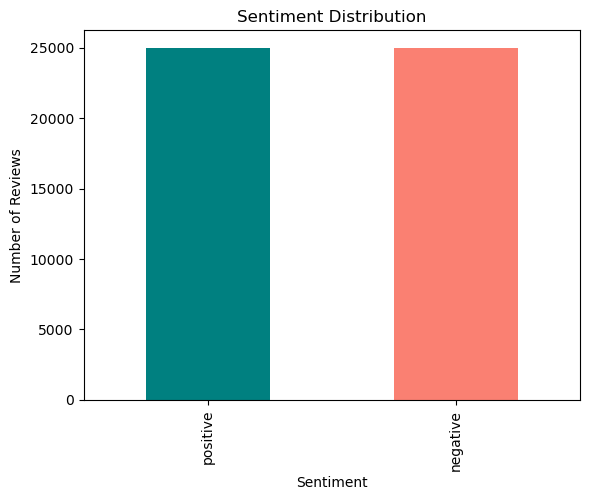

In [11]:
reviews_df['sentiment'].value_counts().plot(kind='bar', color=['teal', 'salmon'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

As we can see the positive and negative distributions are equidistributed

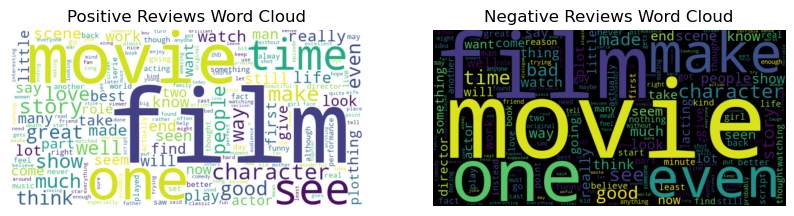

In [12]:
# lets plot length

from wordcloud import WordCloud

df = reviews_df

positive_reviews = ' '.join(df[df['sentiment'] == 'positive']['cleaned_text'])
negative_reviews = ' '.join(df[df['sentiment'] == 'negative']['cleaned_text'])

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color='black').generate(negative_reviews)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')

plt.show()


There are quite a few common words across the sentiments. 

In [13]:
# lets plot most common 2-grams and 3-grams
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

def plot_ngrams_by_sentiment(corpus, sentiments, n=2, top_k=20):
    """
    Plots the top k most frequent n-grams for both positive and negative sentiment.

    Args:
    - corpus (list of str): The text data to analyze.
    - sentiments (list or Series): The corresponding sentiment labels (assumed to be 'positive' or 'negative').
    - n (int): The n in n-grams (e.g., 1 for unigrams, 2 for bigrams, etc.).
    - top_k (int): The number of most frequent n-grams to display for each sentiment.

    Returns:
    - None: Displays bar plots of the top_k n-grams for each sentiment.
    """
    # Separate the corpus into positive and negative reviews
    positive_corpus = [text for text, sentiment in zip(corpus, sentiments) if sentiment == 'positive']
    negative_corpus = [text for text, sentiment in zip(corpus, sentiments) if sentiment == 'negative']

    # Function to obtain top n grams
    def extract_top_ngrams(corpus, n, top_k):
        vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq[:top_k]

    # Extract top n-grams for positive and negative sentiments
    top_positive_ngrams = extract_top_ngrams(positive_corpus, n, top_k)
    top_negative_ngrams = extract_top_ngrams(negative_corpus, n, top_k)

    # Convert to DataFrames for plotting
    df_positive = pd.DataFrame(top_positive_ngrams, columns=['Ngram', 'Frequency'])
    df_negative = pd.DataFrame(top_negative_ngrams, columns=['Ngram', 'Frequency'])

    # Plotting using Seaborn
    plt.figure(figsize=(14, 6))

    # Positive Sentiment Plot
    plt.subplot(1, 2, 1)
    sns.barplot(x='Frequency', y='Ngram', data=df_positive, palette='Blues_d')
    plt.title(f'Top {top_k} {n}-grams in Positive Reviews')
    plt.xlabel('Frequency')
    plt.ylabel(f'{n}-grams')

    # Negative Sentiment Plot
    plt.subplot(1, 2, 2)
    sns.barplot(x='Frequency', y='Ngram', data=df_negative, palette='Reds_d')
    plt.title(f'Top {top_k} {n}-grams in Negative Reviews')
    plt.xlabel('Frequency')
    plt.ylabel(f'{n}-grams')

    plt.tight_layout()
    plt.show()



/var/folders/qb/s5krf8hs7vd4grsxc6wf29nc0000gn/T/ipykernel_98297/2010673111.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Ngram', data=df_positive, palette='Blues_d')
/var/folders/qb/s5krf8hs7vd4grsxc6wf29nc0000gn/T/ipykernel_98297/2010673111.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Ngram', data=df_negative, palette='Reds_d')


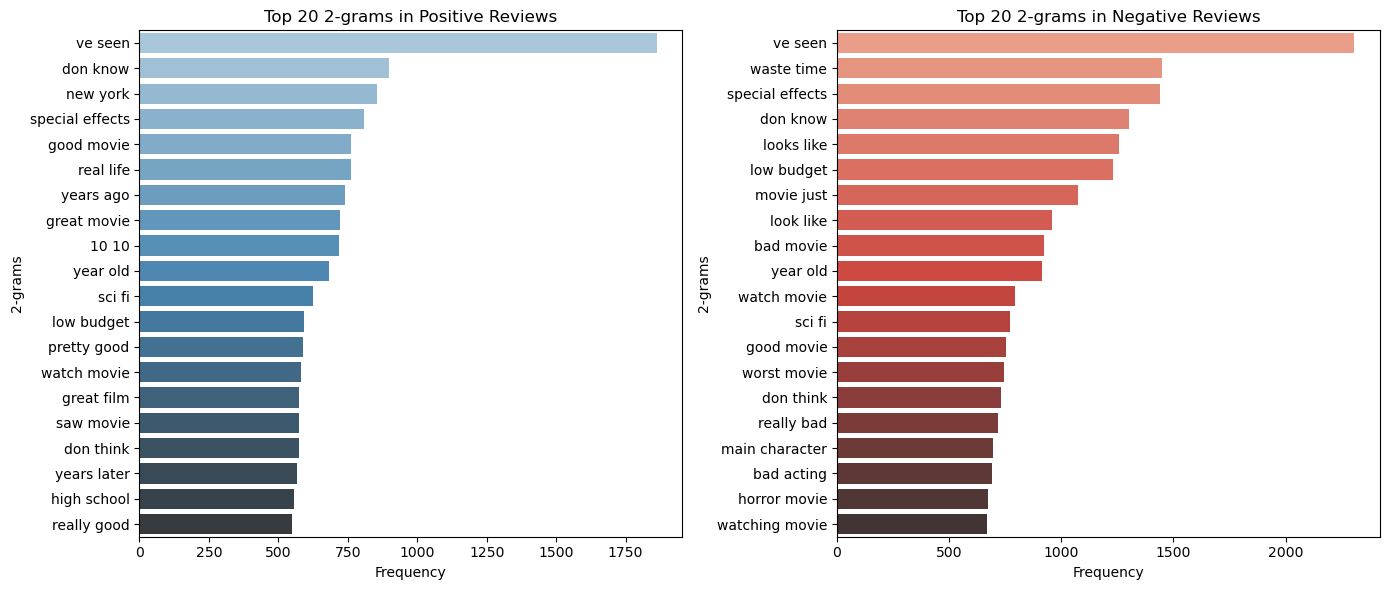

In [14]:
corpus = reviews_df['cleaned_text']
sentiment = reviews_df['sentiment']
plot_ngrams_by_sentiment(corpus, sentiment, n=2, top_k=20)

/var/folders/qb/s5krf8hs7vd4grsxc6wf29nc0000gn/T/ipykernel_98297/2010673111.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Ngram', data=df_positive, palette='Blues_d')
/var/folders/qb/s5krf8hs7vd4grsxc6wf29nc0000gn/T/ipykernel_98297/2010673111.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Ngram', data=df_negative, palette='Reds_d')


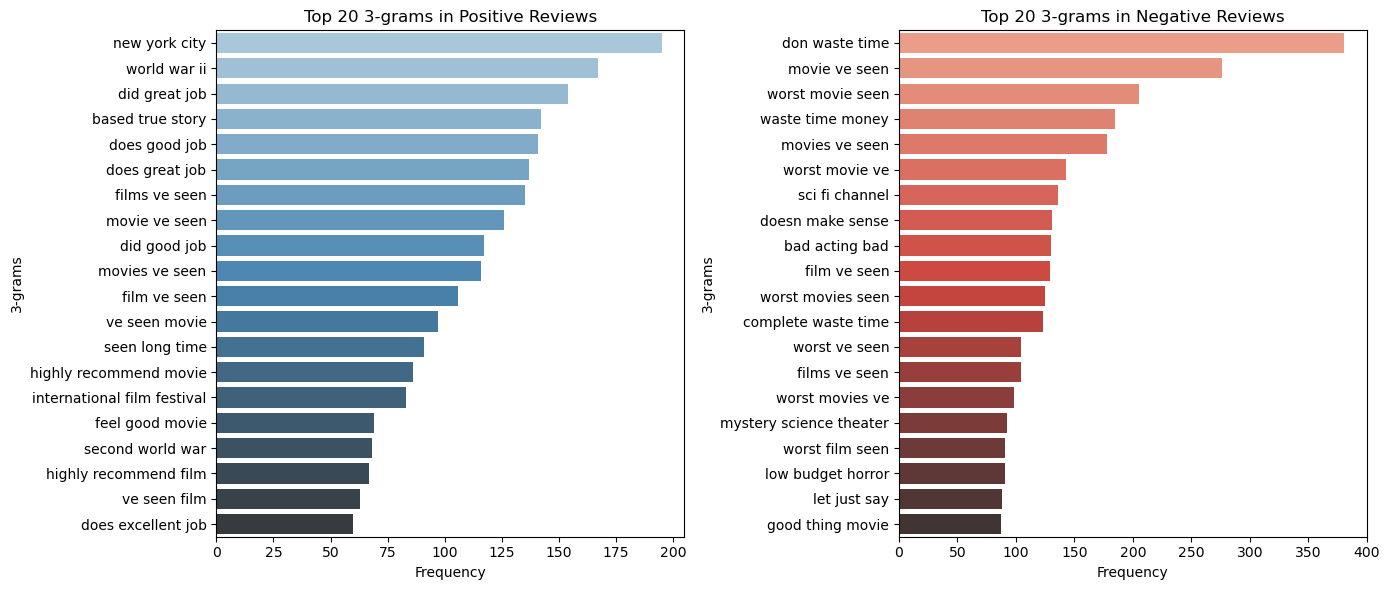

In [15]:
plot_ngrams_by_sentiment(corpus, sentiment, n=3, top_k=20)

Both bigrams and trigrams both seem to be distinct between sentiments. We should definitely incorporate these. 

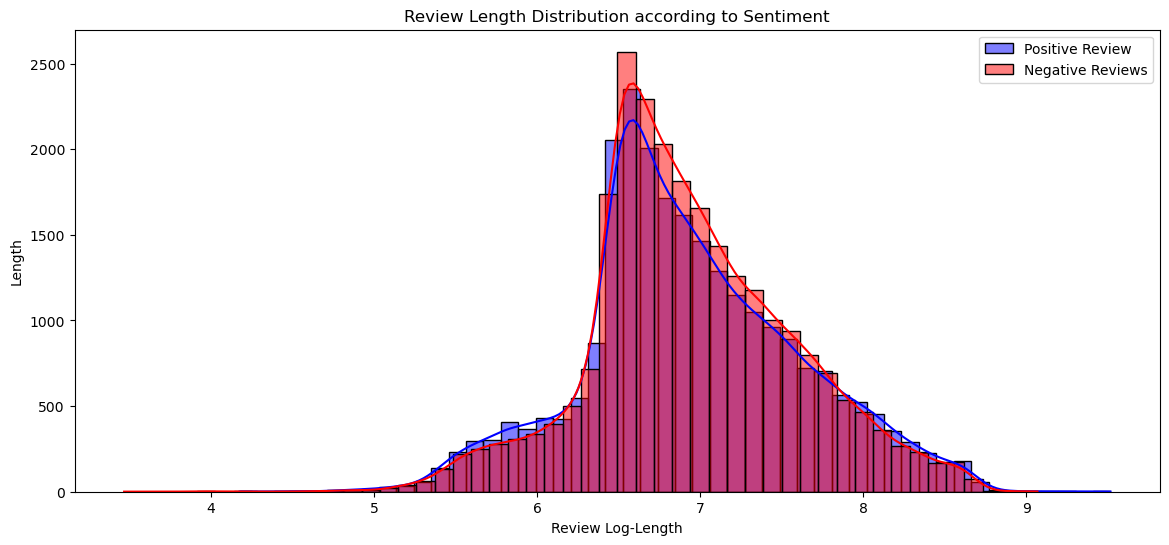

In [16]:
# distribution of lengths
reviews_df['length'] = reviews_df['cleaned_text'].apply(len)
reviews_df['log_length'] = reviews_df['cleaned_text'].apply(lambda x: np.log(len(x)))

# plt.figure(figsize=(10, 5))
# sns.histplot(reviews_df['length'], bins=50, kde=True)
positive_reviews = reviews_df[reviews_df['sentiment'] == 'positive']
negative_reviews = reviews_df[reviews_df['sentiment'] == 'negative']

plt.figure(figsize=(14, 6))

sns.histplot(positive_reviews['log_length'], bins=50, kde=True, color='blue', label='Positive Review')
sns.histplot(negative_reviews['log_length'], bins=50, kde=True, color='red', label='Negative Reviews')

plt.title("Review Length Distribution according to Sentiment")
plt.xlabel('Review Log-Length')
plt.ylabel("Length")
plt.legend()

plt.show()

Interestingly, the distribution shape is the same but the positive reviews are longer. I doubt this feature will be useful in predicting the sentiment. 

# Data Preprocessing

We will be using TfIdf and Word2Vec to create vectorizations. For these, its best to lower case, remove stop words, and lemmatize. We use SpaCy for this. 

In [17]:
import spacy
from tqdm.notebook import tqdm

tqdm.pandas()

# Load the spaCy model, disabling unnecessary components
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'textcat'])


In [19]:
def preprocess_text(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct
    ]

    return ' '.join(tokens)

In [ ]:
# Apply the preprocessing function and save for later use
reviews_df['preprocessed_text'] = reviews_df['cleaned_text'].progress_apply(preprocess_text)
reviews_df.to_csv("preprocessed_dataset.csv")

# Auxiliary Functions

We define some functions we will use frequently later on related to evaluation of our models. 

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report, confusion_matrix


def create_confusion_df(y_val, y_pred):

    # Create a DataFrame for the confusion matrix
    confusion_df = pd.DataFrame(confusion_matrix(y_val, y_pred),
                                index=['Actual Negative', 'Actual Positive'],
                                columns=['Predicted Negative', 'Predicted Positive'])

    return confusion_df

def get_results(y_val, y_pred):
    # Accuracy on the validation set
    val_accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Detailed classification report on the validation set
    print("Classification Report (Validation):")
    print(classification_report(y_val, y_pred))

    # Confusion matrix on the validation set
    print("Confusion Matrix (Validation):")
    print(create_confusion_df(y_val, y_pred))


In [10]:
# auxiliary function to create UMAP for features
import umap.umap_ as umap
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

sentiment_label_mapping = {'positive':  1, 'negative': 0}

def create_umap(X, y, n_components=2):

    # first scale X as UMAP expects values between 0 and 1
    X_scaled = MinMaxScaler().fit_transform(X)

    # initialize and fit a UMAP
    mapper = umap.UMAP(n_components = n_components, metric='cosine').fit(X_scaled)

    df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
    df_emb['label'] = y.apply(lambda x: sentiment_label_mapping[x])

    fig, axes = plt.subplots(1, 2, figsize = (7,5))
    axes = axes.flatten()
    cmaps = ['Blues', 'Reds']
    labels = y

    for i, (label, cmap) in enumerate(zip(labels, cmaps)):
        df_emb_sub = df_emb.query(f"label == {i}")
        axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], cmap = cmap, gridsize=20, linewidths=(0,))
        axes[i].set_title(label)
        axes[i].set_xticks([]), axes[i].set_yticks([])

    plt.tight_layout()
    plt.show()




# Modeling Approaches

We will explore a variety of different approaches based on 1. vectorizatoin and 2. ML algorithms we can use to perform this task. 

## TF-IDF Vectorization

Now we explore using TF-IDF vectorization and various classical ML approaches on top of that to perform this classification task. 

In [4]:
reviews_df = pd.read_csv('preprocessed_dataset.csv')

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(reviews_df['preprocessed_text'])

TfidfVectorizer(max_features=5000)

In [6]:
# split the data
from sklearn.model_selection import train_test_split

X = vectorizer.transform(reviews_df['preprocessed_text'])
y = reviews_df['sentiment']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred_logreg = log_reg.predict(X_val)

In [11]:
get_results(y_val, y_pred_logreg)

Validation Accuracy: 0.8815
Classification Report (Validation):
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      3689
    positive       0.87      0.90      0.88      3811

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500

Confusion Matrix (Validation):
                 Predicted Negative  Predicted Positive
Actual Negative                3196                 493
Actual Positive                 396                3415


### Support Vector Machine

In [33]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
y_val_pred = svm_model.predict(X_val)

In [ ]:
get_results(y_val, y_val_pred)

Validation Accuracy: 0.8797
Classification Report (Validation):
              precision    recall  f1-score   support

    negative       0.88      0.87      0.88      3689
    positive       0.88      0.89      0.88      3811

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500

Confusion Matrix (Validation):
                 Predicted Negative  Predicted Positive
Actual Negative                3213                 476
Actual Positive                 426                3385


### Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_val_pred = rf_model.predict(X_val)

In [13]:
get_results(y_val, y_val_pred)


Validation Accuracy: 0.8469
Classification Report (Validation):
              precision    recall  f1-score   support

    negative       0.84      0.86      0.85      3689
    positive       0.86      0.84      0.85      3811

    accuracy                           0.85      7500
   macro avg       0.85      0.85      0.85      7500
weighted avg       0.85      0.85      0.85      7500

Confusion Matrix (Validation):
                 Predicted Negative  Predicted Positive
Actual Negative                3155                 534
Actual Positive                 614                3197


### XGBoost

In [14]:
from xgboost import XGBClassifier

y_train_processed = (y_train == 'positive')
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train_processed)
y_val_pred = xgb_model.predict(X_val)


In [16]:
y_val_processed = (y_val == 'positive')
get_results(y_val_processed, y_val_pred)

Validation Accuracy: 0.8504
Classification Report (Validation):
              precision    recall  f1-score   support

       False       0.86      0.83      0.85      3689
        True       0.84      0.87      0.86      3811

    accuracy                           0.85      7500
   macro avg       0.85      0.85      0.85      7500
weighted avg       0.85      0.85      0.85      7500

Confusion Matrix (Validation):
                 Predicted Negative  Predicted Positive
Actual Negative                3064                 625
Actual Positive                 497                3314


### Naive Bayes

In [17]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_val_pred = nb_model.predict(X_val)


In [18]:
get_results(y_val, y_val_pred)

Validation Accuracy: 0.8449
Classification Report (Validation):
              precision    recall  f1-score   support

    negative       0.84      0.84      0.84      3689
    positive       0.85      0.85      0.85      3811

    accuracy                           0.84      7500
   macro avg       0.84      0.84      0.84      7500
weighted avg       0.84      0.84      0.84      7500

Confusion Matrix (Validation):
                 Predicted Negative  Predicted Positive
Actual Negative                3109                 580
Actual Positive                 583                3228


### MLP

In [19]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
y_val_pred = mlp_model.predict(X_val)


In [20]:
get_results(y_val, y_val_pred)

Validation Accuracy: 0.8587
Classification Report (Validation):
              precision    recall  f1-score   support

    negative       0.86      0.85      0.86      3689
    positive       0.86      0.86      0.86      3811

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500

Confusion Matrix (Validation):
                 Predicted Negative  Predicted Positive
Actual Negative                3149                 540
Actual Positive                 520                3291


### SGD classifier

In [21]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(loss='hinge', random_state=42)
sgd_model.fit(X_train, y_train)
y_val_pred = sgd_model.predict(X_val)


In [22]:
get_results(y_val, y_val_pred)

Validation Accuracy: 0.8803
Classification Report (Validation):
              precision    recall  f1-score   support

    negative       0.89      0.86      0.88      3689
    positive       0.87      0.90      0.88      3811

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500

Confusion Matrix (Validation):
                 Predicted Negative  Predicted Positive
Actual Negative                3182                 507
Actual Positive                 391                3420


It appears that with TF-IDF vectorization the best we can achieve is ~88%

## Word2Vec Vectorization

First we train a word2vec

In [144]:
preprocessed_text = reviews_df['preprocessed_text'].apply(lambda x: x.split()).tolist()
preprocessed_text[0][:5]

['reviewer', 'mention', 'watch', '1', 'oz']

In [24]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    sentences=preprocessed_text, 
    vector_size=300, 
    window=10, 
    min_count=20,
    workers=6, 
    sg=1
)

w2v_model.train(preprocessed_text, total_examples=len(preprocessed_text), epochs=10)

(46055577, 52084340)

In [25]:
# save for later use
w2v_model.save('imdb_w2v_model.model')

In [26]:
w2v_model.wv.most_similar('good')

[('great', 0.7305521965026855),
 ('well', 0.6570773124694824),
 ('excellent', 0.6236611604690552),
 ('think', 0.6104472875595093),
 ('bad', 0.5989065766334534),
 ('decent', 0.5988683104515076),
 ('like', 0.5970835089683533),
 ('movie', 0.5846737027168274),
 ('nice', 0.5735543370246887),
 ('pretty', 0.5674085021018982)]

I experimented a bit with different settings for the word2vec model, but regardless the word 'bad' always seems to be similar 'good'. 

#### Feature Extraction

In [27]:
def get_average_word2vec(tokens_list, model, vector_size):
    feature_vec = np.zeros(vector_size, dtype='float32')
    n_tokens = 0

    for token in tokens_list:
        if token in model.wv:
            n_tokens += 1
            feature_vec = np.add(feature_vec, model.wv[token])
    
    # avoid division by zero
    if n_tokens > 0:
        feature_vec = feature_vec / n_tokens
    
    return feature_vec


In [28]:
vector_size = w2v_model.vector_size
reviews_df['word2vec_features'] = reviews_df['preprocessed_text'].str.split().apply(lambda x: get_average_word2vec(x, w2v_model, vector_size))

In [29]:
# create train, val, test split
X = np.stack(reviews_df['word2vec_features'].values)
X.shape

(50000, 300)

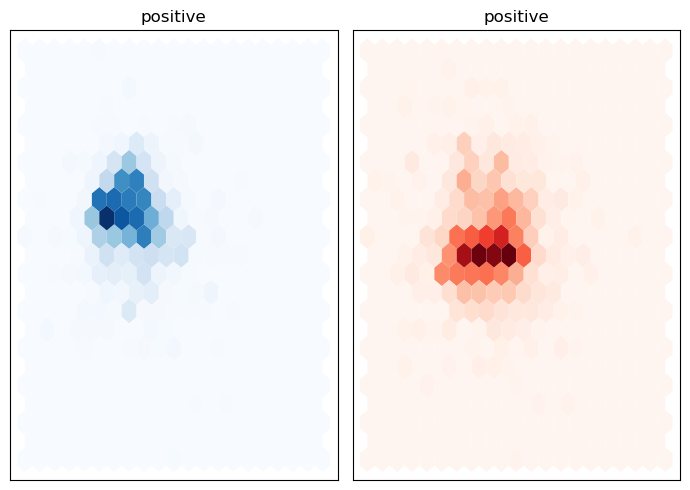

In [31]:
# We visualize a low dimensional projection of these vectors via UMAP. 
create_umap(X, reviews_df['sentiment'])

In [30]:
from sklearn.model_selection import train_test_split

y = reviews_df['sentiment']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Logistic regression

In [32]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train, y_train)

y_pred = log_clf.predict(X_val)

In [33]:
get_results(y_val, y_pred)

Validation Accuracy: 0.8817
Classification Report (Validation):
              precision    recall  f1-score   support

    negative       0.88      0.88      0.88      3689
    positive       0.88      0.89      0.88      3811

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500

Confusion Matrix (Validation):
                 Predicted Negative  Predicted Positive
Actual Negative                3234                 455
Actual Positive                 432                3379


### SVC

In [ ]:
from sklearn.svm import SVC

# Initialize the SVM model
svm_clf = SVC(kernel='rbf', random_state=42)  # You can also try 'rbf' for non-linear classification

# Train the model
svm_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_clf.predict(X_val)

In [ ]:
get_results(y_val, y_pred_svm)

Validation Accuracy: 0.8847
Classification Report (Validation):
              precision    recall  f1-score   support

    negative       0.89      0.88      0.88      3689
    positive       0.88      0.89      0.89      3811

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500

Confusion Matrix (Validation):
                 Predicted Negative  Predicted Positive
Actual Negative                3239                 450
Actual Positive                 415                3396


### Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_val)

In [35]:
get_results(y_val, y_pred)

Validation Accuracy: 0.8313
Classification Report (Validation):
              precision    recall  f1-score   support

    negative       0.85      0.80      0.82      3689
    positive       0.82      0.86      0.84      3811

    accuracy                           0.83      7500
   macro avg       0.83      0.83      0.83      7500
weighted avg       0.83      0.83      0.83      7500

Confusion Matrix (Validation):
                 Predicted Negative  Predicted Positive
Actual Negative                2965                 724
Actual Positive                 541                3270


### Gradient Boosting Classifier

In [36]:
from xgboost import XGBClassifier

# Initialize the XGBoost model
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Train the model
y_train_processed = (y_train == 'positive')
xgb_clf.fit(X_train, y_train_processed)

y_pred = xgb_clf.predict(X_val)

In [37]:
y_val_processed = (y_val == 'positive')
get_results(y_val_processed, y_pred)

Validation Accuracy: 0.8625
Classification Report (Validation):
              precision    recall  f1-score   support

       False       0.87      0.85      0.86      3689
        True       0.86      0.87      0.87      3811

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500

Confusion Matrix (Validation):
                 Predicted Negative  Predicted Positive
Actual Negative                3146                 543
Actual Positive                 488                3323


### MLP classifier

In [38]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50,), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)
y_val_pred = mlp_model.predict(X_val)

In [41]:
get_results(y_val_processed, y_pred)

Validation Accuracy: 0.8625
Classification Report (Validation):
              precision    recall  f1-score   support

       False       0.87      0.85      0.86      3689
        True       0.86      0.87      0.87      3811

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500

Confusion Matrix (Validation):
                 Predicted Negative  Predicted Positive
Actual Negative                3146                 543
Actual Positive                 488                3323


### SGD classifier

In [42]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(loss='log_loss', random_state=42)
sgd_model.fit(X_train, y_train)
y_val_pred = sgd_model.predict(X_val)

In [43]:
get_results(y_val, y_val_pred)

Validation Accuracy: 0.8768
Classification Report (Validation):
              precision    recall  f1-score   support

    negative       0.87      0.89      0.88      3689
    positive       0.89      0.87      0.88      3811

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500

Confusion Matrix (Validation):
                 Predicted Negative  Predicted Positive
Actual Negative                3276                 413
Actual Positive                 511                3300


So the initial findings indicate that the difference between using a TF-IDF vectorization and Word2Vec doesn't make much of an impact on performance. Many of the classic ML algorithms perform similarly across, but its interesting to see that logistic regression seems to perform the best on the validation set in both cases. 

We will now move onto to using a DistilBERT as a feature extractor. 

## DistilBERT vectorization

In [49]:
# import libraries
import transformers
from datasets import load_dataset

In [45]:
# We will now only use the cleaned text when using DistilBERT. Recreating the train, val, test split

df = pd.read_csv('cleaned_reviews.csv')

label_mapping = {'positive': 1, 'negative': 0}

# Add in numerical version of sentiment
df['label'] = df['sentiment'].apply(lambda sentiment: label_mapping[sentiment])

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_df

,review,sentiment,cleaned_text,label
0,"As much as I love trains, I couldn't stomach t...",negative,"As much as I love trains, I couldn't stomach t...",0
1,"This was a very good PPV, but like Wrestlemani...",positive,"This was a very good PPV, but like Wrestlemani...",1
2,Not finding the right words is everybody's pro...,negative,Not finding the right words is everybody's pro...,0
3,I'm really suprised this movie didn't get a hi...,positive,I'm really suprised this movie didn't get a hi...,1
4,I'll start by confessing that I tend to really...,negative,I'll start by confessing that I tend to really...,0
...,...,...,...,...
34995,`Shadow Magic' recaptures the joy and amazemen...,positive,`Shadow Magic' recaptures the joy and amazemen...,1
34996,I found this movie to be quite enjoyable and f...,positive,I found this movie to be quite enjoyable and f...,1
34997,Avoid this one! It is a terrible movie. So wha...,negative,Avoid this one! It is a terrible movie. So wha...,0
34998,This production was quite a surprise for me. I...,positive,This production was quite a surprise for me. I...,1


In [46]:
# save files
train_df.to_csv("imdb_train.csv", index=False)
val_df.to_csv("imdb_val.csv", index=False)
test_df.to_csv("imdb_test.csv", index=False)

In [47]:
train_df

,review,sentiment,cleaned_text,label
0,"As much as I love trains, I couldn't stomach t...",negative,"As much as I love trains, I couldn't stomach t...",0
1,"This was a very good PPV, but like Wrestlemani...",positive,"This was a very good PPV, but like Wrestlemani...",1
2,Not finding the right words is everybody's pro...,negative,Not finding the right words is everybody's pro...,0
3,I'm really suprised this movie didn't get a hi...,positive,I'm really suprised this movie didn't get a hi...,1
4,I'll start by confessing that I tend to really...,negative,I'll start by confessing that I tend to really...,0
...,...,...,...,...
34995,`Shadow Magic' recaptures the joy and amazemen...,positive,`Shadow Magic' recaptures the joy and amazemen...,1
34996,I found this movie to be quite enjoyable and f...,positive,I found this movie to be quite enjoyable and f...,1
34997,Avoid this one! It is a terrible movie. So wha...,negative,Avoid this one! It is a terrible movie. So wha...,0
34998,This production was quite a surprise for me. I...,positive,This production was quite a surprise for me. I...,1


In [50]:
# create a dataset
reviews_ds = load_dataset('csv', data_files={'train': 'imdb_train.csv', 'validation': "imdb_val.csv", 'test': 'imdb_test.csv'})

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [51]:
reviews_ds

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label'],
        num_rows: 35000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label'],
        num_rows: 7500
    })
    test: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label'],
        num_rows: 7500
    })
})

### Visualize the Data

Before moving on, lets gather some stats on word length and distribution between the splits. 

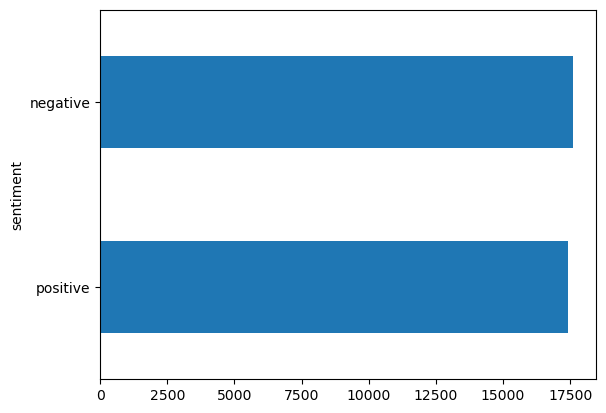

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

train_df['sentiment'].value_counts(ascending=True).plot.barh()
plt.show()

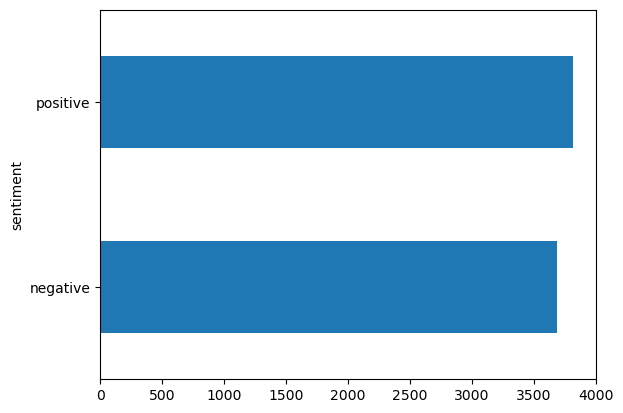

In [53]:
val_df['sentiment'].value_counts(ascending=True).plot.barh()
plt.show()

Ok great! The labels are well balanced in both the training and validation sets. 

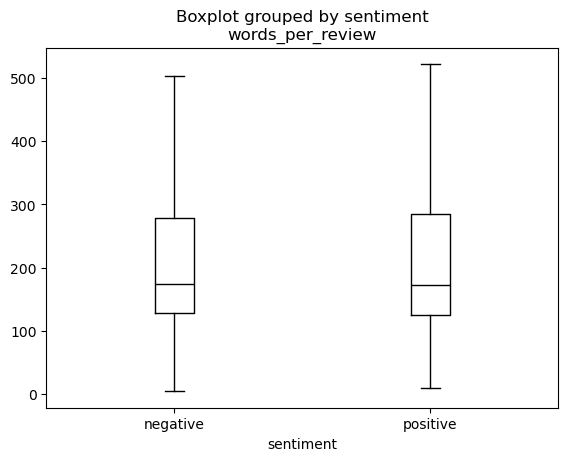

In [54]:
# lets get lengths
df['words_per_review'] = df['review'].str.split().apply(len)
df.boxplot('words_per_review', by='sentiment', grid=False, showfliers=False, color='black')
plt.show()

In [55]:
# get max length
df['words_per_review'].describe()

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: words_per_review, dtype: float64

So the vast majority of reviews are below 500 words, so I think we can use the max number of tokens as 512 and the truncation method without worrying too much. 

### Download a DistilBERT model and its tokenizer

In [56]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [57]:
tokenizer.model_max_length

512

In [58]:
def tokenize(batch):
    return tokenizer(batch['cleaned_text'], padding='max_length', truncation=True, max_length=512)

In [59]:
# example of tokenizer's output
tokenize(reviews_ds['train'][:2])

{'input_ids': [[101, 2004, 2172, 2004, 1045, 2293, 4499, 1010, 1045, 2481, 1005, 1056, 4308, 2023, 3185, 1012, 1996, 18458, 2008, 2028, 2071, 8954, 1037, 8098, 1998, 1000, 3298, 1000, 2013, 6751, 2000, 3190, 2302, 7294, 2178, 3345, 2247, 1996, 2126, 2038, 2000, 2022, 2157, 2039, 2045, 2006, 1996, 5263, 5436, 3210, 2718, 2604, 1012, 5674, 2048, 4487, 28745, 15532, 14782, 9274, 5126, 11065, 1996, 1000, 13529, 2121, 1000, 2008, 2000, 4570, 1996, 10382, 2015, 2000, 1998, 10424, 2080, 1998, 4439, 2009, 2000, 2047, 2259, 1998, 2017, 2131, 1996, 2801, 1012, 2383, 2056, 2035, 2008, 1010, 2009, 1005, 1055, 1037, 3835, 3046, 1012, 19863, 3877, 7987, 14428, 2135, 2003, 2012, 2010, 18844, 1051, 11149, 2190, 1010, 1998, 23310, 2239, 16254, 4332, 1037, 2204, 2836, 2004, 2010, 11737, 9148, 16190, 2021, 2092, 1011, 3574, 29240, 1012, 3960, 21451, 8193, 2003, 4848, 8231, 15485, 2100, 2004, 1996, 5971, 3124, 1010, 1998, 1996, 1000, 2210, 3124, 3138, 2006, 2175, 6632, 2705, 1000, 2466, 4152, 2178, 10499,

In [60]:
# tokenize the entire dataset
tokenized_ds = reviews_ds.map(tokenize, batched=True, batch_size=64)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

In [61]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 35000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7500
    })
    test: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7500
    })
})

In [62]:
# set device
import torch

# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


Using device: mps


In [63]:
# Download a pretrained DistilBert model
from transformers import AutoModel

model_ckpt = 'distilbert-base-uncased'
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [64]:
text = 'this is a test'
inputs = tokenizer(text, return_tensors='pt')
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [65]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [66]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [67]:
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)
print(outputs.last_hidden_state.shape)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='mps:0'), hidden_states=None, attentions=None)
torch.Size([1, 6, 768])


In [68]:
# We will extract the last hidden state associated with the [CLS]
def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [69]:
tokenized_ds.set_format("torch", columns = ['input_ids', 'attention_mask', 'label'])

In [70]:
# extract the last hidden state for each review in the dataset
reviews_hidden = tokenized_ds.map(extract_hidden_states, batched=True, batch_size=32)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

In [71]:
reviews_hidden

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 35000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 7500
    })
    test: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 7500
    })
})

In [72]:
import numpy as np

# Convert the extracted features to a NumPy array if they aren't already
train_features = np.concatenate([batch['hidden_state'] for batch in reviews_hidden['train']])
val_features = np.concatenate([batch['hidden_state'] for batch in reviews_hidden['train']])
test_features = np.concatenate([batch['hidden_state'] for batch in reviews_hidden['train']])

X_train.shape, y_train.shape

((35000, 300), (35000,))

In [73]:
# Save the features to a .npy file for later use
np.save('train_features.npy', train_features)
np.save('val_features.npy', val_features)
np.save('test_features.npy', test_features)

In [74]:
# Create a feature matrix 
X_train = np.array(reviews_hidden['train']['hidden_state'])
X_val = np.array(reviews_hidden['validation']['hidden_state'])
y_train = np.array(reviews_hidden['train']['label'])
y_val = np.array(reviews_hidden['validation']['label'])

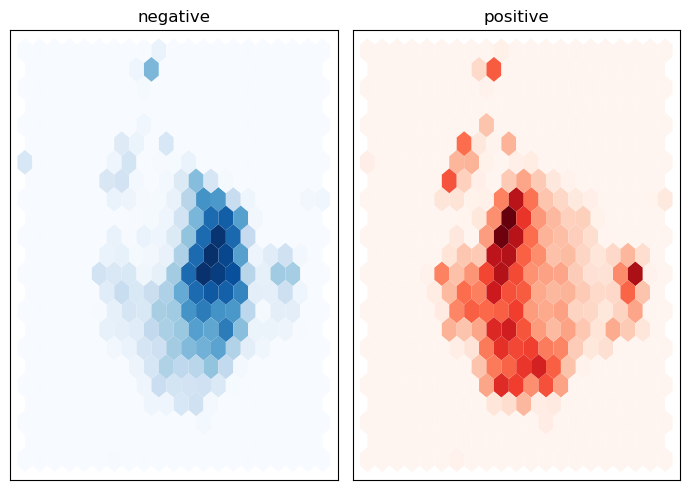

In [79]:
# Visualize the BERT features
create_umap(X_train, train_df['sentiment'])

### ML models trained on BERT features

In [80]:
# lets start with a logistic regression model on the hidden states to see.
from sklearn.linear_model import LogisticRegression

logreg_clf = LogisticRegression(max_iter=1000)
logreg_clf.fit(X_train, y_train)
y_pred = logreg_clf.predict(X_val)

In [81]:
get_results(y_val, y_pred)

Validation Accuracy: 0.8793
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      3689
           1       0.89      0.87      0.88      3811

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500

Confusion Matrix (Validation):
                 Predicted Negative  Predicted Positive
Actual Negative                3278                 411
Actual Positive                 494                3317


In [82]:
from sklearn.svm import SVC

# Initialize the SVM model
svm_clf = SVC(kernel='linear', random_state=42) 
# Train the model
svm_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_clf.predict(X_val)

In [83]:
get_results(y_val, y_pred)

Validation Accuracy: 0.8803
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      3689
           1       0.89      0.87      0.88      3811

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500

Confusion Matrix (Validation):
                 Predicted Negative  Predicted Positive
Actual Negative                3271                 418
Actual Positive                 480                3331


In [84]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_val)

In [85]:
get_results(y_val, y_pred)

Validation Accuracy: 0.8331
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      3689
           1       0.85      0.82      0.83      3811

    accuracy                           0.83      7500
   macro avg       0.83      0.83      0.83      7500
weighted avg       0.83      0.83      0.83      7500

Confusion Matrix (Validation):
                 Predicted Negative  Predicted Positive
Actual Negative                3119                 570
Actual Positive                 682                3129


It appears that even when using feature vectors obtained via a pretrained DistilBERT model, the classical ML algorithms still perform at similar accuracies as those using vectors from TF-IDF and Word2Vec. Next we will actually fine tune the DistilBERT model. 

## Fine-tune a DistilBERT model

In [ ]:
# set device
import torch

# Check if MPS is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


Using device: cuda


Note: The cells below were run separately on Kaggle as couldn't get Hugging Face to work on my Mac M1 chip. When writing the training loop manually using PyTorch, training was painfully slow, so I decided to run the rest on Kaggle to access GPUs

In [ ]:
from transformers import AutoModelForSequenceClassification

model_ckpt = 'distilbert-base-uncased'
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)
model.to(device)

In [ ]:
model.device

device(type='cuda', index=0)

In [87]:
tokenized_ds.set_format("torch", columns = ['input_ids', 'attention_mask', 'label'])
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 35000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7500
    })
    test: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7500
    })
})

In [88]:
# define the metrics we will use

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [89]:
from transformers import Trainer, TrainingArguments
import accelerate

# define the training hyperparameters
batch_size=16
logging_steps = len(tokenized_ds['train']) // batch_size
model_name = f"{model_ckpt}-finetuned-sentiment"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy='epoch',
    disable_tqdm=False,
    logging_steps=logging_steps,
    log_level='error'
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['validation'],
    tokenizer=tokenizer
)
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.184631,0.928800,0.928727
2,0.191100,0.190157,0.935600,0.935602
3,0.191100,0.228271,0.937467,0.937457


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=3282, training_loss=0.15497577488240782, metrics={'train_runtime': 3192.3712, 'train_samples_per_second': 32.891, 'train_steps_per_second': 1.028, 'total_flos': 1.390907685888e+16, 'train_loss': 0.15497577488240782, 'epoch': 3.0})

In [ ]:
# Next we evaluate

preds_output = trainer.predict(tokenized_ds['validation'])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [ ]:
preds_output.metrics

{'test_loss': 0.22827140986919403,
 'test_accuracy': 0.9374666666666667,
 'test_f1': 0.9374568528832582,
 'test_runtime': 75.3872,
 'test_samples_per_second': 99.486,
 'test_steps_per_second': 3.117}

Based on this, we achieve a much better accuracy and F1 score on after finetuning a DistilBERT model. Lets take a look at the confusion matrix next. 

In [125]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels, normalize=False):
    cm = confusion_matrix(y_true, y_preds, normalize='true' if normalize else None)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [ ]:
y_preds

array([1, 1, 0, ..., 1, 1, 0])

In [ ]:
y_valid = tokenized_ds['validation']['label']
y_valid

tensor([0, 1, 0,  ..., 1, 1, 0])

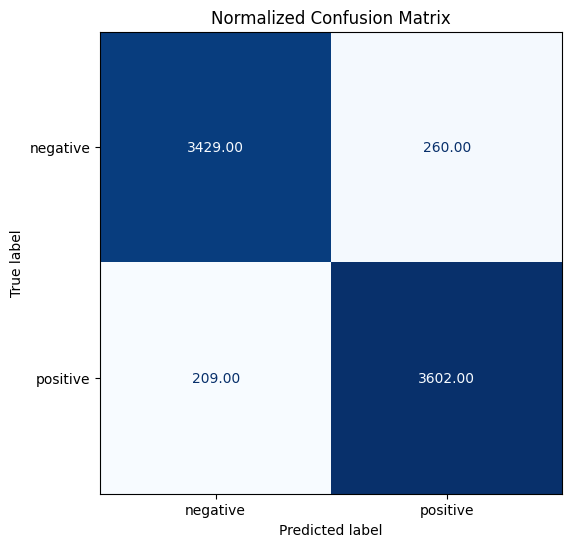

In [ ]:
plot_confusion_matrix(y_preds, y_valid, ['negative', 'positive'])

We have roughly the same number of False Negatives and False Positives. Next we will take a look at the mislabeled examples and order them according to their loss. But first, let's save the model to WandB for later use. 

In [ ]:
# lets save the model to wandb
import wandb

if wandb.run:
    print(f"WandB run is active: {wandb.run.id}")
else:
    print("No WandB run is currently active.")
    run = wandb.init(project="imdb-reviews-sentiment-analysis", entity="dominic-l-culver")



No WandB run is currently active.


In [ ]:
model.save_pretrained('/kaggle/working/final_model/model')
tokenizer.save_pretrained('/kaggle/working/final_model/tokenizer')

In [ ]:
artifact = wandb.Artifact('distilbert-finetuned-imdb', type='model')

artifact.add_dir('/kaggle/working/final_model')

wandb.log_artifact(artifact)

wandb: Adding directory to artifact (/kaggle/working/final_model)... Done. 1.7s


<Artifact distilbert-finetuned-imdb>

### Analysis of misclassified reviews

Now we take a closer look at how the reviews in the validation set were classified as well as take a look at the loss for each example. At this point, I started working on my local machine again, so I need to first download my fine-tuned model from WandB. 

In [ ]:
# download the artifact of running this notebook on another machine

model_artifact = wandb.use_artifact('dominic-l-culver/imdb-reviews-sentiment-analysis/distilbert-finetuned-imdb:latest', type='model')
model_dir = model_artifact.download()



wandb: Downloading large artifact distilbert-finetuned-imdb:latest, 511.30MB. 10 files... 
wandb:   10 of 10 files downloaded.  
Done. 0:0:0.3


In [101]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model
model = AutoModelForSequenceClassification.from_pretrained('artifacts/distilbert-finetuned-imdb:v0/model')

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('artifacts/distilbert-finetuned-imdb:v0/tokenizer')


In [104]:
# Set device to MPS if available, otherwise default to CPU
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Move model to the selected device
model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [105]:
# verify things are working correctly
# Example input text
input_text = "This is a fantastic movie!"

# Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt")  # 'pt' for PyTorch
inputs

{'input_ids': tensor([[  101,  2023,  2003,  1037, 10392,  3185,   999,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [106]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch['label'].to(device), reduction='none')
    
    return {"loss": loss.cpu().numpy(), 'predicted_label': pred_label.cpu().numpy()}
    

In [107]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 35000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7500
    })
    test: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7500
    })
})

In [108]:
tokenized_ds.set_format("torch", columns = ['input_ids', 'attention_mask', 'label'])

# compute loss values
tokenized_ds['validation'] = tokenized_ds['validation'].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

In [110]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 35000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
        num_rows: 7500
    })
    test: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7500
    })
})

In [111]:
# lets look at the misclassified examples
df = pd.DataFrame({
    'Text': tokenized_ds['validation']['cleaned_text'],
    'True Label': tokenized_ds['validation']['label'],
    'Sentiment': tokenized_ds['validation']['sentiment'],
    'Predicted Label': tokenized_ds['validation']['predicted_label'],
    'loss': tokenized_ds['validation']['loss']
})
df

,Text,True Label,Sentiment,Predicted Label,loss
0,CORRIDORS OF BLOOD Aspect ratio: 1.66:1Sound f...,0,negative,1,4.317923
1,I was pretty surprised with this flick. Even t...,1,positive,1,0.002315
2,"This movie was really bad, plain and simple. H...",0,negative,0,0.001243
3,"It's not funny, it's not interesting, it's not...",0,negative,0,0.001282
4,I saw this recently on a cable channel. The mo...,1,positive,1,0.002634
...,...,...,...,...,...
7495,"Unless you're twelve, this movie really isn't ...",0,negative,0,0.001440
7496,Just an hour ago I finished watching this my f...,0,negative,0,0.015601
7497,I can't tell you all how much I love this movi...,1,positive,1,0.004786
7498,The Last Hunt is one of the few westerns ever ...,1,positive,1,0.003277


In [112]:
misclassified_df = df[df['True Label'] != df['Predicted Label']]
misclassified_df

,Text,True Label,Sentiment,Predicted Label,loss
0,CORRIDORS OF BLOOD Aspect ratio: 1.66:1Sound f...,0,negative,1,4.317923
20,Hunters chase what they think is a man through...,0,negative,1,1.657506
33,Jean Seberg had not one iota of acting talent....,0,negative,1,2.289992
47,Long trailer? whoever said that has got to be ...,1,positive,0,3.909483
49,"Yumiko (Wakana Sakai), the pretty adopted daug...",0,negative,1,0.926250
...,...,...,...,...,...
7434,"Pendragon Pictures' new film ""H G Wells' War o...",1,positive,0,0.998630
7435,"This is a kind of genre thing, meaning you eit...",0,negative,1,5.794190
7439,"One of low budget horror schlockmeister actor,...",0,negative,1,3.677488
7483,For anyone who may not know what a one-actor m...,1,positive,0,4.865289


In [113]:
misclassified_df.sort_values("loss", ascending=False, inplace=True)
misclassified_df.head(10)

/var/folders/qb/s5krf8hs7vd4grsxc6wf29nc0000gn/T/ipykernel_9834/215619341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df.sort_values("loss", ascending=False, inplace=True)


,Text,True Label,Sentiment,Predicted Label,loss
3011,I saw this movie when Mystery Science Theater ...,1,positive,0,6.808529
4692,I just don't understand why this movie is gett...,1,positive,0,6.662829
1548,I haven't read the Anne Rice novel that this m...,1,positive,0,6.581000
883,Verhoeven's movie was utter and complete garba...,1,positive,0,6.501717
3953,The only reason I wanted to see this was becau...,1,positive,0,6.483173
3493,This low-budget erotic thriller that has some ...,1,positive,0,6.471783
2013,While this outing certainly doesn't live up to...,0,negative,1,6.465236
1067,I'm a bit conflicted over this. The show is on...,1,positive,0,6.422463
875,"The romance of the movie, which is also its ma...",1,positive,0,6.422447
6892,I remember this film as the other person that ...,1,positive,0,6.411437


In [114]:
pd.set_option("display.max_colwidth", None)

In [115]:
misclassified_df.head(10)

,Text,True Label,Sentiment,Predicted Label,loss
3011,"I saw this movie when Mystery Science Theater ran it in 1993. It is the worst thing I've ever seen. So bad in fact, that by sheer freakiness, this movie must get a ten rating because it has to be seen to be believed. Whoever wrote this script with children in mind should be beaten. I mean, really, the Devil vs. Santa? Visions of Hell? Creepy laughing wind-up reindeer? Forced Child labor with racial stereotypes? It ain't Sesame Street, that's for sure.As Crow exclaims during the MST3K showing, ""This is good ol' fashioned nightmare fuel!"" There's plenty of weird innuendo and screwed up theology. Merlin (presumably the Arthurian Merlin) hangs out with Santa in his crazy castle in the clouds (i.e. Heaven). Santa talks about baby Jesus and sends letters to ""Mr. Stork"" for children who ask for siblings. There are symbols around the castle that either look like pentagrams or RAF stars. My best friend and I have watch it every year since 1993 and we subject anybody we can hold down for 2 hours to watch it with us.",1,positive,0,6.808529
4692,"I just don't understand why this movie is getting beat-up in here. Jeez. It is mindless, it isn't polished and it is (as I am reading) wasted on some. The cast of this movie plays their characters to the 'T' (If you watched Permanent Midnight and became a Ben Stiller fan then yes you will be disappointed). These are misunderstood, well-intentioned misfits trying to save the city/world with nothing but grit and determination. The problem is they don't realize their limits until the big showdown and that's the point! This is 3 times the movie that The Spy Who Shagged Me was yet gets panned by the same demographic group, likely the same people who feel the first AP movie pales in comparison to the sequel. I just don't get it. The jokes work on more then one level; if you didn't get it I know what level you're at.",1,positive,0,6.662829
1548,"I haven't read the Anne Rice novel that this movie was based on, but who knows, maybe reading the book is cheaper than renting QUEEN OF THE DAMNED and is probably better for your health. It isn't that this movie is necessarily bad for your health, but a book can be very relaxing and certainly exercises the active part of your brain more so than this movie. You can count the number of pages by Anne Rice that I've read on one hand, but after seeing this movie and Interview with a Vampire, I get the feeling that she writes really good novels. The plots for both movies hint at a whole sea of deep and interwoven vampire history.Still, Stuart Townsend's voice-over narration gets a heck of a lot more annoying than Brad Pitt's vampire narrative ever did, and you can tell that QUEEN OF THE DAMNED's limited production resources barely give enough flesh to the Anne Rice storyline. While Interview decided to go with lace and elegance, QUEEN relies on low budget special effects that try really hard to be taken seriously. One can see that the original novel had potential as a movie and that the production team focused its attention in the wrong places. The costumes and rock & roll stage could have been replaced with more blood and an eerier soundtrack.However, I'll give credit where credit is due. The soundtrack is excellent. Korn and Disturbed had me down with the sickness bobbing my noggin like Butthead.The film opens with a very cool Goth-rock zoom & splice montage, but after the first ten minutes or so, the directing degenerates quickly. It's as if the movie was so long that the director realized that there wasn't enough time and enough money to do an Anne Rice novel justice. What results are some mediocre vampire scenes and plenty of cheesy special effects. Unfortunately, QUEEN OF THE DAMNED fails to do the genre justice just as its John Carpenter counterparts fail to impress. Where are the yellow contacts? Where's the pale blue make-up? Scene after scene, I shook my head reminiscing about the days of Salem's Lot 

In [116]:
misclassified_df.tail(10)

Text  \
3202                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Critics love this movie. I personally found it senseless and tasteless. This is the millionth time I've fallen into the "critics love it" trap and came out wishing someone would throw boiling hot water on my testicles because it was less painful than watching the movie. There are many scenes that are completely unnecessary. A warning to A

For the misclassified reviews a cursory glance indicates that a common element is sarcasm, this may be something that our model cannot detect. Also, the loss is bounded bwelow by ~0.69. 

Next, we will take a look at the loss 

In [117]:
df.sort_values('loss', ascending = False, inplace=True)
properly_classified = df[df['True Label'] == df['Predicted Label']]

In [118]:
properly_classified

,Text,True Label,Sentiment,Predicted Label,loss
6487,"an very good storyline, good thrill to it ... but the 10 last seconds destroyed the whole movie... what happened? extremely well made and an good story destroyed in the last seconds... sorry to say but a 1 in vote... thats what it it deserve, i would think that Chris Shadley could come up with a better end... but maybe next time : ) all this meaningless blood gore for nothing? the end would lift the story to close to a 10, but it didn't.... the end destroyed the whole story, i think most people aren't lame and when they goes a movie thy want a good end, even if it is intricate ... but the only lame here is the end... sorry",0,negative,0,0.685392
7053,"Soon Americans would swarm over a darkened, damaged England preparing to invade Europe, but in 1937 the picture of hip Americans in the sunny, slightly ridiculous English countryside was an appealing, idyllic diversion. American dancing star & heartthrob Jerry Halliday (Astaire), on a European tour & weary of the screaming female crowds generated by the lurid propaganda of his manager (Burns), is unwittingly caught up in the marriage prospects of frustrated heiress Lady Alice Marshmorton (Fontaine). The tale is complicated by a betting pool among the Marshmorton servants that is run by (and rigged for) head butler Keggs (Gardiner), who's betting on Lady Alice's cousin Reggie (Noble), the favorite of Alice's stuffy, domineering aunt (Collier). The story would have been much better as a half-hour TV episode. The usual Wodehouse plot devices of mistaken identity and jumps to wrong conclusions wear thin in a full-length film. Both Alice & Jerry appear impossibly (and annoyingly) clueless by the second half of the film. The amusement park interlude & the climax in the castle are too long & begin to drag. Fontaine is too beautiful, too dignified & too quiet to be a ditzy blonde, no matter how aristocratic, while young footman Albert (Watson) is painfully awful. But while ""Damsel"" is a pretty diminutive vehicle for so much talent, the talent doesn't let us down. Astaire's romantic comedy skill is no less enjoyable here than in any of his films with Ginger Rogers and his dance scenes, both solo & with Burns & Allen, are up to par, though his one dance with novice hoofer Joan is necessarily tame. Gracie nearly steals the whole show as George's bubbly secretary who is at once airheaded, conniving & coolly self-confident. Her scene with solid character actor Gardiner as the devious snob Keggs is a one-of-a-kind classic. This & Astaire's priceless scene with the madrigal singers give ""Damsel"" a delightful color of naive but noble-spirited Americans mixing with noble but dull-spirited Englishmen. Gershwin is at the top of his game with ""Nice Work if You Can Get it"" & ""Stiff Upper Lip,"" which carry the film through its weak points. And is there another film where madrigals get a Gershwin swing treatment? ""Damsel"" is more than a piece of trivia for those who might want to see Astaire without Rogers or Fontaine before she was a real star. It's a fine diversion as entertaining as any of the vaudevillian musical comedies that ruled the 1930s but will never be made again.",1,positive,1,0.683079
2144,"Once again Bronson's talent is mostly wasted on this shock value 1984 thriller which (uncut) is far more disturbing than most of what is out even today. The fact that ""The Evil That Men Do"" is very disturbing (in its verbal and visual depictions of torture) is not the problem. It is the shameless gratuity in which it is presented. Interestingly, this film seems to symbolize that latter part of Bronson's career in which he has tortured many of his fans with the same egregiously predictable and uncreative plots. One hopes this fine actor will rise again.",0,negative,0,0.681676
1430,"A very slick modern (keeping it sensually hip) revamp on the Dracula story (although staying with the traditional customs) with quite an interesting, if not fu

An interesting observation to make from the above is that the highest occurring loss of the properly classified reviews is ~ 0.685 whereas the lowest occurring loss of the misclassified examples is ~0.695. We will incorporate this when making predictions.

In [120]:
def predict_with_threshold(batch, threshold=0.69):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch['label'].to(device), reduction='none')
        
        # invert predictions where loss is exceeded
        inverted_preds = torch.where(loss > threshold, 1-pred_label, pred_label)
        
        return{"modified_prediction": inverted_preds}
        

In [121]:
# compute loss values
tokenized_ds['validation'] = tokenized_ds['validation'].map(predict_with_threshold, batched=True, batch_size=16)

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

In [122]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 35000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label', 'modified_prediction'],
        num_rows: 7500
    })
    test: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7500
    })
})

In [123]:
updated_df = pd.DataFrame({
    'Text': tokenized_ds['validation']['cleaned_text'],
    'True Label': tokenized_ds['validation']['label'],
    'Sentiment': tokenized_ds['validation']['sentiment'],
    'Predicted Label': tokenized_ds['validation']['predicted_label'],
    'Modified Prediction': tokenized_ds['validation']['modified_prediction'],
    'loss': tokenized_ds['validation']['loss']
})
updated_df

,Text,True Label,Sentiment,Predicted Label,Modified Prediction,loss
0,"CORRIDORS OF BLOOD Aspect ratio: 1.66:1Sound format: Mono(Black and white)London, 1840: Whilst attempting to formulate an anaesthetic solution, a dedicated surgeon (Boris Karloff) becomes addicted to narcotics and is blackmailed by local bodysnatchers.Riding the coat-tails of a Gothic revival occasioned by the recent success of Hammer's THE CURSE OF FRANKENSTEIN (1957), Robert Day's CORRIDORS OF BLOOD is an odd mixture of historical drama and Grand Guignol theatrics. Producer Richard Gordon lured Karloff away from Hollywood - where his movie career had become stalled in a B-movie rut (VOODOO ISLAND, FRANKENSTEIN 1970, etc.) - for a couple of lurid shockers in which good men are thwarted by circumstances beyond their control. In GRIP OF THE STRANGLER (1958), he played a novelist who stumbles onto a horrific secret whilst researching a series of murders from recent history, while in CORRIDORS OF BLOOD, he's a drug-addicted surgeon who falls prey to a gang of criminals masterminded by East End pub landlord Francis de Wolff. Less a horror film than a melodrama with ghoulish trimmings, the movie hedges its commercial bets by including a number of gory thrills (a leg sliced open, a face destroyed by acid, etc.), but the narrative is motivated chiefly by Karloff's altruistic pursuit of an anaesthetic formula that will alleviate the terrible suffering of patients during surgery.Produced under the title 'The Doctor from Seven Dials', the finished movie went unreleased until 1962 due to indifference by distributors MGM, by which time co-star Christopher Lee had earned a prominent screen credit, despite playing a small - but significant - role as 'Resurrection Joe', a sinister Cockney thug who murders carefully selected patrons of de Wolff's squalid pub and sells the remains to local doctors. Lee filmed this glorified cameo before THE CURSE OF FRANKENSTEIN catapulted him to international stardom, which accounts for his limited screen time, though his intense performance is one of the film's highlights. Adrienne Corri (VAMPIRE CIRCUS) distinguishes herself as de Wolff's partner in crime, and there's a feast of familiar faces in supporting roles, including Francis Matthews (DRACULA: PRINCE OF DARKNESS), Betta St. John (THE CITY OF THE DEAD), Finlay Currie and Nigel Green. Superb art direction (by Anthony Masters) and cinematography (Geoffrey Faithful).",0,negative,1,0,4.317923
1,I was pretty surprised with this flick. Even though their budjet was obviously lacking still you have to be impressed that this movie took 7 years to make and still turned out good. The acting was pretty impressive and the story really captivated me. My only complaint would be that the ending really was a little too abrupt for my taste. But hey if your audience is left wanting more then this movie has succeeded.I would really recommend anyone in Hollywood to look up Antonella Ríos who is an excellent Spanish talent (something hard to find now days with all the bad novela over acting). Antonella Ríos truly is a star on the rise.,1,positive,1,1,0.002315
2,"This movie was really bad, plain and simple. How a movie like this gets wide release is a wonder to me.It's a decent idea, but it just didn't flesh out. Edward Burns is a decent actor though. I liked his small role in Saving Private Ryan.Let's get down to the big issue here.The visuals were so incredibly bad, I thought I was watching an old ""Dinosaurs In 3D"" CDROM point-and-click adventure demo on Windows 3.1 I mean, I've seen cut-scenes in console games from pre-2000 that have better looking dinosaurs than this. I mean, heck... the original Tomb Raider T-Rex looked better than this one.The lizard-monkeys were laughable. I thought they were some sort of ripoff creation from ""Killer Instinct"" I've seen better sock-puppet monsters now that I think about it.You know, there's a ton of made-for-TV movies that are better than this. How does a gem 

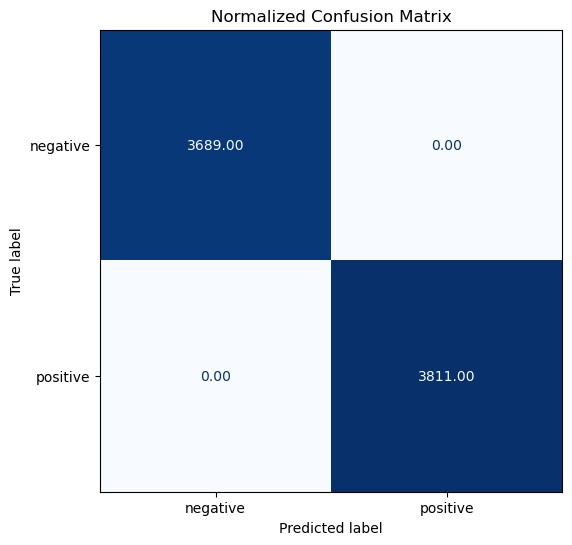

In [126]:
plot_confusion_matrix(updated_df['Modified Prediction'], updated_df['True Label'], ['negative', 'positive'])

Unsuprisingly the model performs perfectly on the validation set when adding in this modified prediction scheme. Lets see how it performs on the test set. 

In [128]:
tokenized_ds['test'] = tokenized_ds['test'].map(forward_pass_with_label, batched=True, batch_size=16)

tokenized_ds['test'] = tokenized_ds['test'].map(predict_with_threshold, batched=True, batch_size=16)

tokenized_ds

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 35000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label', 'modified_prediction'],
        num_rows: 7500
    })
    test: Dataset({
        features: ['review', 'sentiment', 'cleaned_text', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label', 'modified_prediction'],
        num_rows: 7500
    })
})

In [134]:
updated_test_df = pd.DataFrame({
    'Text': tokenized_ds['test']['cleaned_text'],
    'True Label': tokenized_ds['test']['label'],
    'Sentiment': tokenized_ds['test']['sentiment'],
    'Predicted Label': tokenized_ds['test']['predicted_label'],
    'Modified Prediction': tokenized_ds['test']['modified_prediction'],
    'loss': tokenized_ds['test']['loss'],
})


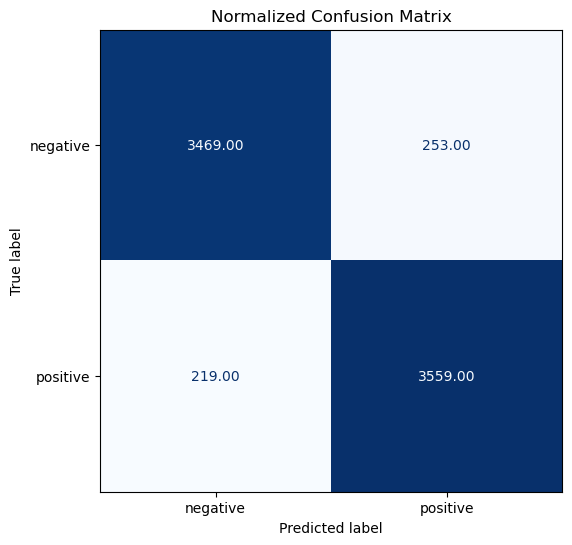

In [137]:
# get the confusion matrix for the unmodified and modified predictions
plot_confusion_matrix(updated_test_df['Predicted Label'], updated_test_df['True Label'], ['negative', 'positive'])

In [138]:
get_results(updated_test_df['True Label'], updated_test_df['Predicted Label'])

Validation Accuracy: 0.9371
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      3722
           1       0.93      0.94      0.94      3778

    accuracy                           0.94      7500
   macro avg       0.94      0.94      0.94      7500
weighted avg       0.94      0.94      0.94      7500

Confusion Matrix (Validation):
                 Predicted Negative  Predicted Positive
Actual Negative                3469                 253
Actual Positive                 219                3559


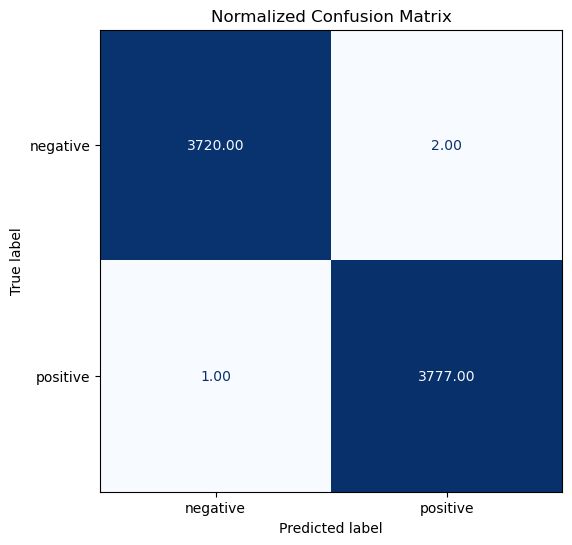

In [136]:
plot_confusion_matrix(updated_test_df['Modified Prediction'], updated_test_df['True Label'], ['negative', 'positive'])

In [139]:
get_results(updated_test_df['True Label'], updated_test_df['Modified Prediction'])

Validation Accuracy: 0.9996
Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3722
           1       1.00      1.00      1.00      3778

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Confusion Matrix (Validation):
                 Predicted Negative  Predicted Positive
Actual Negative                3720                   2
Actual Positive                   1                3777


As we can see, the model performs similarly on the test set as the validation set, which suggests we aren't overfitting! Moreover, the modified scheme to make predictions performs nearly perfectly on the test set as well, suggesting we made a nearly perfect choice of threshold. 

# Questions

There are some questions that I think are worth pondering based on what we saw during this project. 

1. Why is it the case that the classical ML algorithms (e.g. logistic regression or random forests) performed similarly regardless of vectorization technique? After fine-tuning our DistilBERT, would the new features lead to better performance from classical ML algorithms?
2. The raw predictions from our fine-tuned distilBERT seemed to peak at around 93% accuracy on the validation set. Could we do better or is there a fundamental limitation to the architecture we used?
3. A cursory glance at the misclassified reviews that came out of our fine-tuned model suggests that sarcasm was a key factor in leading to misclassification. Are there others, or is sarcasm the only source? 
4. Related to the first one, how could we modify our architecture to teach the model to also detect sarcasm?